# Introduction to Quantum Computing #

## MITP 2023

The aim of this notebook is to introduce the reader to using quantum devices, specifically superconducting qubit devices such as those being developed and produced by IBM. Most of the code will be written in Qiskit, with brief introductions to other quantum computing languages which will needed for the rest of the course. 

# Qiskit

In this section we will introduce the Qiskit language, manipulating single and multiqubit states using the set of [universal quantum gates](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html). The tutorial will lead up to the SWAP test algorithm, which is prolific in quantum machine learning.

In [1]:
### Import required packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit import (QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute)
from qiskit.quantum_info import Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *

## The qubit

The building block of superconducting quantum devices is the so called qubit, the quantum analogue of the classical bit. The state of the qubit can be modelled as point on the surface of a three-dimensional Bloch sphere, such that a state $\vert \psi\rangle$ can be written as 

$$
\vert \psi \rangle = \cos \frac{\theta}{2} \vert 0 \rangle + e^{i\phi}\sin \frac{\theta}{2} \vert 1 \rangle,
$$

where $0\leq\theta<\pi$ and $0\leq\phi<2\pi$ corrspond to angles on the Bloch sphere. The state can then be manipulated by rotating the vector using the rotation

$$
U_3 (\theta, \phi, \lambda) = \begin{pmatrix} \cos \big( \frac{\theta}{2} \big) & - e^{i\lambda} \sin \big( \frac{\theta}{2} \big) \\ e^{i\phi} \sin \big( \frac{\theta}{2} \big) & e^{i(\phi + \lambda)} \cos \big( \frac{\theta}{2} \big) \end{pmatrix},
$$

where $e^{i\lambda}$ is a phase which has observable effect, as only the relative phase between the two basis states $\vert0\rangle$ and $\vert1\rangle$ has a physical meaning. 

The $U_3$ rotation is realised in Qiskit using the `QuantumCircuit.u(\theta, \phi, \lambda, qubit)` gate operation, demonstrated below:

1) The qubit is initialised in the $\vert 0 \rangle$ state
2) The $U_3$ rotation is applied with parameters $\theta = \pi/2$, $\phi = \pi/4$ and $\lambda = 0$

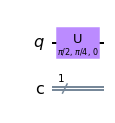

In [2]:
#Initilise quantum circuit object with 1 qubit and 1 classical readout bit
circuit = QuantumCircuit(1, 1)
#Apply U_3 roation
circuit.u(np.pi/2, np.pi/4, 0, 0)
#Draw circuit
circuit.draw('mpl')

We can now plot the qubit as a Bloch shere using the `StateVector` method, which provides the statevector of each qubit in the quantum circuit. Here, we only have one qubit and so one Bloch sphere, but we can plot using `plot_bloch_multivector(state)` which will plot a Bloch sphere diagram for all qubits in the circuit.

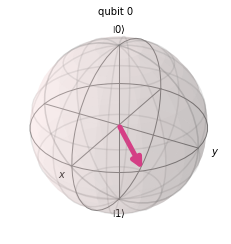

In [3]:
#Get state vector from the circuit
state = Statevector(circuit)
#Plot Bloch sphere
plot_bloch_multivector(state)

We now want to perform a measurement on the qubit and run the circuit on a quantum device. The device we will use here is the `qasm_simulator` available through Aer (runs locally). 

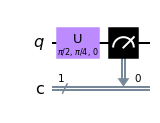

In [4]:
#Measure qubit to classical bit
circuit.measure(0, 0)

circuit.draw('mpl')

In [5]:
#Load the backend we want
sim = Aer.get_backend('qasm_simulator')
#Run the circuit on the quantum simulator from Aer (runs locally)
#for 1000 shots on the device
job = execute(circuit, sim, shots=1000)
job_monitor(job) #monitors the job's progression (useful when running on IBMQ)
#Retrieve the number of counts for each state measured
counts = job.result().get_counts()
print(counts)

Job Status: job has successfully run
{'0': 506, '1': 494}


We now have a dictionary of counts against measured states (the states are classical bit strings). Here we have used a projective measurement 

$$
\vert{\psi}\rangle \hspace{5pt} \longrightarrow{M_m} \hspace{5pt} \vert{\psi^\prime}\rangle = \frac{M_m\vert{\psi}\rangle}{\sqrt{\langle{\psi}\vert M^\dagger_m M_m \vert{\psi}\rangle}},
$$

and thus we must run the circuit many times to build a probability distribution. The `counts` dictionary now contains the information about how many times the system was measured in each possible configuration. We can visualise these counts using the `plot_histogram` method from Qiskit.

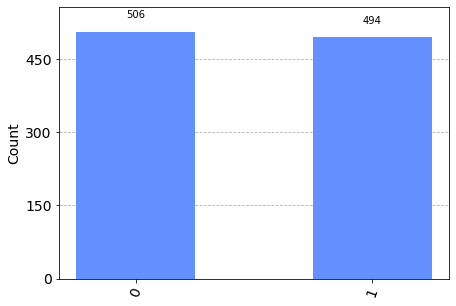

In [6]:
plot_histogram(counts)

## Exercise:

Try making some arbitrary states on a single qubit using the `circuit.u()` gate. Plot the Bloch sphere for these using the `Statevector` operator, and then run on the simulator. Remember to use an appropriate amount of shots to gain the information you have encoded onto the device.

In [ ]:
circuit = QuantumCircuit(1, 1)

#
# Your code here
#

circuit.draw('mpl')

In [ ]:
#Get state vector from the circuit
state = Statevector(circuit)
#Plot Bloch sphere
plot_bloch_multivector(state)

In [ ]:
circuit.measure(0,0)
circuit.draw('mpl')

In [ ]:
job = execute(circuit, sim, shots=...)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Multiple qubits

The state space of a quantum computer grows exponentially with the number of qubits, such that an $n$-qubit system has $2^n$ basis states in the computational basis. These basis states take the form $\vert{q_1q_2,\dots,q_n}\rangle$, where $q_i\in\{0,1\}$.

As a first example, we will construct a Bell state on 2 qubits,

$$
\frac{1}{\sqrt{2}} \big(\vert{00}\rangle + \vert{11}\rangle \big),
$$

and perform a measurement on the qubits. Here we will use the `QuantumRegister` and `ClassicalRegister` objects, which will be useful when we get to more complicated algorithms. The registers are a collection of (qu)bits which we can pass to the QuantumCircuit operation. It makes our life easier when we have many qubits!  

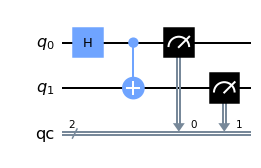

In [7]:
q  = QuantumRegister(2, name='q')
qc = ClassicalRegister(2, name='qc')

bell_state = QuantumCircuit(q, qc)

bell_state.h(q[0])
bell_state.cx(q[0],q[1])

bell_state.measure(q, qc)

bell_state.draw('mpl')

Job Status: job has successfully run


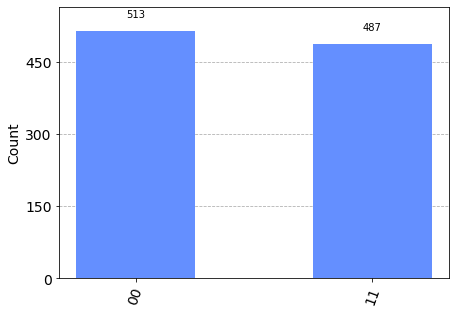

In [8]:
job = execute(bell_state, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

The circuit returns the expected measurement of a Bell state. Let us know run this on a real device to see how noise will affect the result. 

**Here we will use the IBM Quantum Experience. If you haven't signed up for an account yet, please skip the next cell!**

**Please don't all execute this cell at the same time, otherwise some of you could be waiting a long time...**

Job Status: job has successfully run


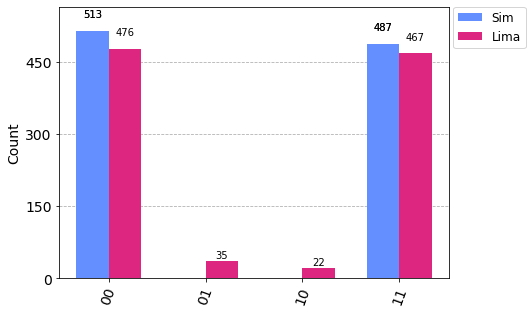

In [9]:
from qiskit_ibm_provider import IBMProvider

#provider = IBMProvider(token=<INSERT_IBM_QUANTUM_TOKEN>)
provider = provider = IBMProvider()
device   = provider.get_backend('ibmq_lima')

job = execute(bell_state, device, shots=1000)
job_monitor(job)
qcounts = job.result().get_counts()
plot_histogram([counts, qcounts], legend=['Sim', 'Lima'])

We see that the quantum computer performs pretty well, but still we can see the effect of noise in the device. 

## Exercise : Build an arbitrary state

Can you write a circuit which builds the following state on two qubits?

$$
\vert \psi \rangle = \frac{1}{\sqrt{3}} \big( \vert 00 \rangle + \vert 10 \rangle + \vert 01 \rangle \big)
$$

Can you do this with minimal circuit depth?

In [ ]:
circuit = QuantumCircuit(2)

#
# Your code here
#

circuit.draw('mpl')

In [ ]:
job = execute(circuit, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Exercise: 

Try building entangled states using the single qubit `circuit.u()` gate and the `circuit.cx()` gate. YOu can try this for many qubits. What is the effect of adding more `CNOT` operations? How do you think this would affect the real device?

In [ ]:
### Your code here

In [ ]:
### Your code here

In [ ]:
### Your code here

# PennyLane

PennyLane is another open source quantum computing language which is very useful for machine learning techniques. In this notebook we will go over the basics of building and executing a circuit in PennyLane.

Here we will use the PennyLane rotations to manipulate a single qubit state. The aim is to construct the state 

$$
\vert \psi \rangle = R_y(\theta) R_x (\phi) \vert 0 \rangle,
$$

where the rotations have the form

$$
R_x(\phi) = e^ {- i \phi \sigma_x/2} = \begin{pmatrix} \cos \frac{\phi}{2} & -i\sin \frac{\phi}{2} \\ -i\sin \frac{\phi}{2} & \cos \frac{\phi}{2} \end{pmatrix},  \hspace{5cm} R_y (\theta) = e^{-i \theta \sigma_y/2} = \begin{pmatrix} \cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\ \sin \frac{\theta}{2} & \cos \frac{\theta}{2} \end{pmatrix}.
$$

Unlike Qiskit, in PennyLane, you must always return a measurement operation. Therefore, in this example, we will measure the expectation value of the Pauli-Z operator, $\sigma_z$, such that 

$$
\langle \psi \vert \sigma_z \vert \psi \rangle = \langle 0 \vert R_x^\dagger (\phi) R_y^\dagger (\theta \sigma_z R_y(\theta) R_x (\phi) \vert 0 \rangle = \cos \phi \cos \theta.
$$

Let's now encode this onto a circuit using PennyLane.

In [10]:
import pennylane as qml
from pennylane import numpy as npl

When coding using PennyLane, it is always important to import the wrapped version of NumPy from Pennylane. To not conflict with the above, we import this version as `npl`. This wrapped version allows you to:

- combine quantum functions (evaluated on quantum hardware/simulators) and classical functions (provided by NumPy)
- allow PennyLane to automatically calculate gradients of both classical and quantum functions

## Creating a device

To start, we must first create a `device` object. This is analogous to loading a backend in Qiskit. For this example, we will use the qubit system with one wire, which is one qubit in the PennyLane language. 

In [11]:
dev1 = qml.device("default.qubit", wires=1)

## Constructing a QNode

Once we have created a device, we must now construct a quantum node ([QNode](https://docs.pennylane.ai/en/stable/code/api/pennylane.QNode.html#pennylane.QNode)). QNodes are an abstract encapsulation of a quantum function, described by a quantum circuit. QNodes are bound to a particular quantum device, which is used to evaluate expectation and variance values of this circuit.

In [12]:
@qml.qnode(dev1, interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

Here we have defined two things. Firstly, we have to construct the quantum function that is to be evaluated by the QNode. Here we build a simple circuit consisting of two rotations, $R_X$ followed by $R_Y$. Building circuits in PennyLane is analogous to Qiskit, however the the circuit function must return either a single or a tuple of measured observables. This reduces the flexibility in building circuits that is on offer from Qiskit, however PennyLane is very powerful when it comes to Quantum Machine Learning. 

Secondly, we must then convert the circuit into a QNode using the `qnode` function. This must be constructed directly above the quantum function definition. Here we define our `circuit` function as a QNode which will run on the `dev1` device each time it is evaluated. 

To evaluate, we just call the quantum function:

In [13]:
phi    = 0.34
theta  = 0.78
result = circuit([phi, theta]) 
print(result)

0.6702170547483379


## Calculating gradients

PennyLane allows for seemless integration of quantum circuits with classsical computing techniques. PennyLane incorporates both analytic differentiation, as well as numerical methods to calculate the gradients of a quantum circuit. This is done using the `grad` function

In [14]:
dcircuit = qml.grad(circuit, argnum=0)

where the `grad` function returns another QNode representing the gradient of the circuit. We can evaluate this QNode in the same way as above

In [15]:
gradient = dcircuit([phi, theta])
print(gradient)

[array(-0.23708049), array(-0.66301995)]


## Exercise:

Can you replicate the circuits you constructed above using Qiskit? Try using different measurements, i.e. the expectation value of the Pauli-X operator, what is the effect?

In [ ]:
### Your code here

In [ ]:
### Your code here

In [ ]:
### Your code here